In [45]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [46]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [47]:
notes = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Notes:', notes)

Notes: ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']


#### Предварительная проверка файлов на соответствие размеру окна

In [48]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label_check(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label, file_path


In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [50]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
output_ds = files_ds.map(get_waveform_and_label_check, num_parallel_calls=AUTOTUNE)

In [51]:
data = []
lengths = []
for a,b,c in output_ds:
    data.append((a.shape[0],b,c))
    lengths.append(a.shape[0])

In [52]:
idx_yes = [] #список индексов файлов с подходящими размерами
idx_no = [] #список индексов файлов с неподходящими размерами 
for a in range(len(lengths)):
    if lengths[a]<8192:
        idx_no.append(a)
    else:
        idx_yes.append(a)
            
print(len(idx_yes))
print(len(idx_no))
print(len(idx_yes)+len(idx_no))

27310
3518
30828


In [53]:
filenames_filtered = []
for i in range(len(filenames)):
    if i in idx_yes:
        filenames_filtered.append(filenames[i])
len(filenames_filtered)

27310

In [54]:
data = None
lengths = None
filenames = filenames_filtered
filenames_filtered = None
idx_no = None
idx_yes = None
output_ds = None
files_ds = None

_______________________

In [55]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 27310
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F\\kr033a_150.wav', shape=(), dtype=string)


In [56]:
# Для удобства разбиения выборки на тренировочную, тестовую и валидационную возьмем только 27000 файлов, 
# которые разобьем в соотношении 70:20:10 

filenames = filenames[:27000]

train_files = filenames[:18900]
val_files = filenames[18900:18900 + 5400]
test_files = filenames[-2700:]

print('Training set size', len(train_files))
print('Val set size', len(val_files))
print('Test set size', len(test_files))

Training set size 18900
Val set size 5400
Test set size 2700


In [57]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11507, 1])

In [58]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [59]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    K = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=K, frame_step=S,fft_length=K,pad_end=False)/np.sqrt(K//2 + 1)
    spectrogram = tf.abs(spectrogram)**2
    return spectrogram


In [60]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    log_spec = np.log(spectrogram.T+np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, width-1, num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [61]:
def get_spectrogram_and_label_id(audio, label, step):
    spectrogram = get_spectrogram((audio,step))
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            #spect_last,_ = tf.nn.moments(x=spectrogram[0:spec_length-1], axes=[0])
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [62]:
def preprocess_dataset(files,s,f):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    #output_ds = output_ds.filter(without_zero_len) 
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,s), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [63]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [64]:
K = 8192
step = list(map(int,[K/32, K/16, K/8, K/4, K/2, K]))
num_frame = [5,10,15,20,25,30]
params_s_f = [] 

for s in step:
    for f in num_frame:
        params_s_f.append((s,f))
print('Количество вариантов step', len(step))
print('Количество вариантов num_frame', len(num_frame))
print('Количество баз данных', len(params_s_f))

Количество вариантов step 6
Количество вариантов num_frame 6
Количество баз данных 36


In [65]:
import time
EPOCHS = 300
batch_size = 64

In [ ]:
from datetime import datetime
import pickle

k=0
print('---------------------------------------------------------------------')
print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

start_time = time.time()
print('Подготовка данных...')
spectr = None
train_ = None
val_ = None
test_ = None
input_shape = None
spectr = preprocess_dataset(train_files,params_s_f[k][0],params_s_f[k][1])
train_=spectr
val_ = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
test_ = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
for spectrogram, _ in spectr.take(1):
    input_shape = spectrogram.shape
print('Размер входных данных: ', input_shape)
train_ = train_.batch(batch_size)
train_ = train_.cache().prefetch(AUTOTUNE)
val_ = val_.batch(batch_size)
val_ = val_.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []
for audio, label in test_:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")
mymodel = create_model(input_shape)
print('Обучение...') 
start_time = time.time()
myhistory = mymodel.fit(train_, validation_data=val_, epochs=50, verbose=1)
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')



In [66]:
from datetime import datetime
import pickle

tests_acc = []
for k in range(len(params_s_f)):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    start_time = time.time()
    print('Подготовка данных...')
    spectr = None
    train_ = None
    val_ = None
    test_ = None
    input_shape = None
    spectr = preprocess_dataset(train_files,params_s_f[k][0],params_s_f[k][1])
    train_=spectr
    val_ = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
    test_ = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
    for spectrogram, _ in spectr.take(1):
        input_shape = spectrogram.shape
    print('Размер входных данных: ', input_shape)
    train_ = train_.batch(batch_size)
    train_ = train_.cache().prefetch(AUTOTUNE)
    val_ = val_.batch(batch_size)
    val_ = val_.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []
    for audio, label in test_:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())
    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)
    
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    mymodel = create_model(input_shape)
    print('Обучение...') 
    start_time = time.time()
    myhistory = mymodel.fit(train_, validation_data=val_, epochs=EPOCHS, verbose=0,
                            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    
    mymodel.save(f"model_stft_{k}.h5")
    
    with open(f'./history_stft_{k}_epoch.data', 'wb') as filehandle:
        # сохраняем данные как двоичный поток
        pickle.dump(myhistory.epoch, filehandle)

    with open(f'./history_stft_{k}_history.data', 'wb') as filehandle:
        # сохраняем данные как двоичный поток
        pickle.dump(myhistory.history, filehandle)



---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  5
2022-06-09 18:37:50
Подготовка данных...
Размер входных данных:  (5, 4097)
--- 0.0 минут 6.780893802642822 секунд ---
Обучение...
--- 2.0 минут 47.043802976608276 секунд ---
85/85 [==============================] - 1s 5ms/step
Шаг: 256 , количество спектрограмм:  5 , accuracy тестовой выборки:  92.2962962962963 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  10
2022-06-09 18:40:45
Подготовка данных...
Размер входных данных:  (10, 4097)
--- 0.0 минут 6.67151141166687 секунд ---
Обучение...
--- 5.0 минут 12.302646160125732 секунд ---
85/85 [==============================] - 1s 8ms/step
Шаг: 256 , количество спектрограмм:  10 , accuracy тестовой выборки:  92.85185185185185 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  15
2022-06-09 18:46:05
Подготовка данных..

Размер входных данных:  (10, 4097)
--- 0.0 минут 3.2488253116607666 секунд ---
Обучение...
--- 6.0 минут 26.506569147109985 секунд ---
85/85 [==============================] - 2s 21ms/step
Шаг: 2048 , количество спектрограмм:  10 , accuracy тестовой выборки:  95.51851851851852 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  15
2022-06-09 21:24:51
Подготовка данных...
Размер входных данных:  (15, 4097)
--- 0.0 минут 3.620718240737915 секунд ---
Обучение...
--- 8.0 минут 15.361231565475464 секунд ---
85/85 [==============================] - 3s 31ms/step
Шаг: 2048 , количество спектрограмм:  15 , accuracy тестовой выборки:  95.62962962962963 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  20
2022-06-09 21:33:14
Подготовка данных...
Размер входных данных:  (20, 4097)
--- 0.0 минут 4.500019550323486 секунд ---
Обучение...
--- 10.0 минут 55.34047770500183 секунд ---
85/

In [67]:
spectr = None
train_ = None
val_ = None
test_ = None
input_shape = None
test_audio = None
test_labels = None
myhistory = None
mymodel = None

In [68]:
np.array(tests_acc)

array([92.2962963 , 92.85185185, 94.51851852, 94.96296296, 95.22222222,
       95.59259259, 93.55555556, 94.85185185, 94.96296296, 95.44444444,
       95.74074074, 95.55555556, 94.85185185, 95.77777778, 95.55555556,
       95.88888889, 95.66666667, 95.74074074, 95.        , 95.51851852,
       95.62962963, 95.96296296, 95.74074074, 95.7037037 , 95.25925926,
       94.77777778, 95.14814815, 95.11111111, 95.37037037, 95.03703704,
       93.40740741, 93.66666667, 93.51851852, 93.18518519, 93.62962963,
       93.14814815])

Text(51.0, 0.5, 'Шаг')

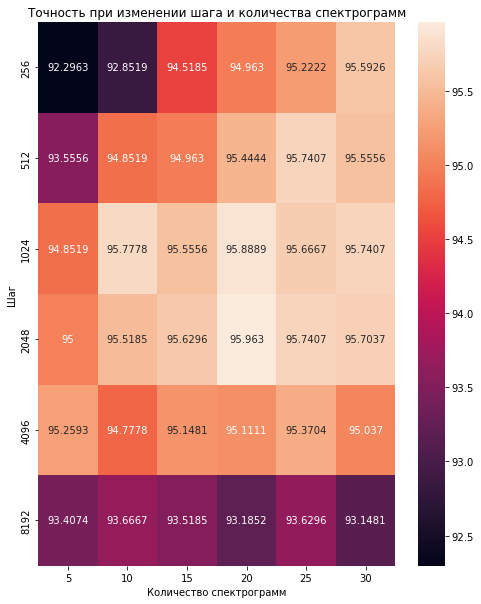

In [69]:
test_acc_mtx = np.zeros((len(step),len(num_frame)))
p = 0
for s in range(len(step)):
    for f in range(len(num_frame)):
        test_acc_mtx[s][f] = tests_acc[p]
        p+=1
plt.figure(figsize=(8, 10))
sns.heatmap(test_acc_mtx, xticklabels=num_frame, yticklabels=step, 
            annot=True, fmt='g')
plt.title('Точность при изменении шага и количества спектрограмм')
plt.xlabel('Количество спектрограмм')
plt.ylabel('Шаг')

In [70]:
for k in range(len(params_s_f)):
    print(k, params_s_f[k],tests_acc[k])

0 (256, 5) 92.2962962962963
1 (256, 10) 92.85185185185185
2 (256, 15) 94.51851851851852
3 (256, 20) 94.96296296296296
4 (256, 25) 95.22222222222221
5 (256, 30) 95.5925925925926
6 (512, 5) 93.55555555555556
7 (512, 10) 94.85185185185185
8 (512, 15) 94.96296296296296
9 (512, 20) 95.44444444444444
10 (512, 25) 95.74074074074073
11 (512, 30) 95.55555555555556
12 (1024, 5) 94.85185185185185
13 (1024, 10) 95.77777777777777
14 (1024, 15) 95.55555555555556
15 (1024, 20) 95.88888888888889
16 (1024, 25) 95.66666666666667
17 (1024, 30) 95.74074074074073
18 (2048, 5) 95.0
19 (2048, 10) 95.51851851851852
20 (2048, 15) 95.62962962962963
21 (2048, 20) 95.96296296296296
22 (2048, 25) 95.74074074074073
23 (2048, 30) 95.7037037037037
24 (4096, 5) 95.25925925925925
25 (4096, 10) 94.77777777777779
26 (4096, 15) 95.14814814814815
27 (4096, 20) 95.11111111111111
28 (4096, 25) 95.37037037037037
29 (4096, 30) 95.03703703703704
30 (8192, 5) 93.4074074074074
31 (8192, 10) 93.66666666666667
32 (8192, 15) 93.5185

In [71]:
k_max = np.argmax(np.array(tests_acc))
k_max

21

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для шага 2048 и 20 спектрограмм')]

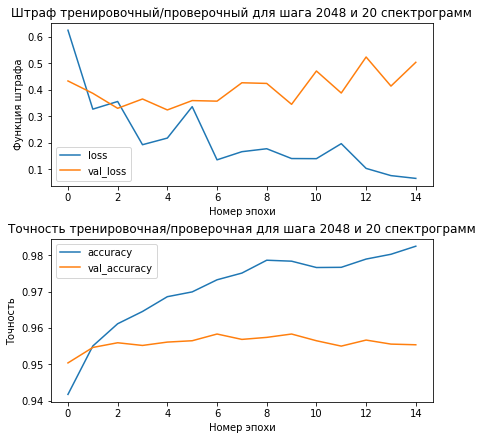

In [72]:
#for k in range(len(params_s_f)):
#for k in range(2):
k = k_max
with open(f'./history_stft_{k}_epoch.data', 'rb') as f:
    h_epoch = pickle.load(f)
with open(f'./history_stft_{k}_history.data', 'rb') as f:
    h_history = pickle.load(f)
#metrics = histories[k].history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(h_epoch, h_history['loss'], h_history['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм')

axes[1].plot(h_epoch, h_history['accuracy'], h_history['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм')

In [73]:
print('Лучшие параметры: ', params_s_f[k_max][0],params_s_f[k_max][1])

Лучшие параметры:  2048 20


In [83]:
from tensorflow.keras.models import load_model
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = preprocess_dataset(train_files,params_s_f[k_max][0],params_s_f[k_max][1])
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_files,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_ = load_model(f"model_stft_{k_max}.h5")

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

85/85 [==============================] - 3s 39ms/step


95.96296296296296

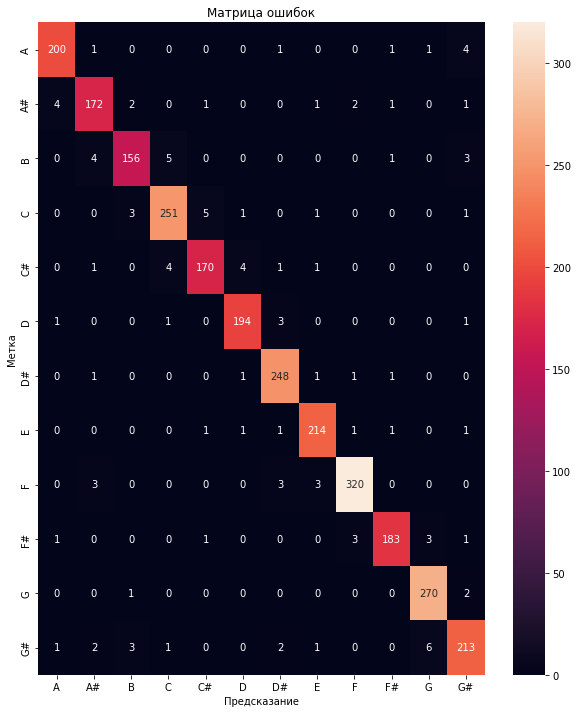

In [84]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


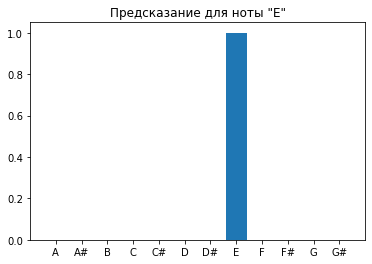

1


In [85]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)

sample_ds = preprocess_dataset([str(sample_file)],params_s_f[k_max][0],params_s_f[k_max][1])
count = 0 
for spectrogram, label in sample_ds.batch(1):
    count+=1
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()
print(count)

In [86]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_stft_new.h5")

In [87]:
model_.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 20, 4097)]        0         
                                                                 
 flatten_23 (Flatten)        (None, 81940)             0         
                                                                 
 relu_1 (Dense)              (None, 512)               41953792  
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 42,485,260
Trainable params: 42,485,260
Non-

C:\Users\belas\AppData\Local\Temp/ipykernel_8904/372374044.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


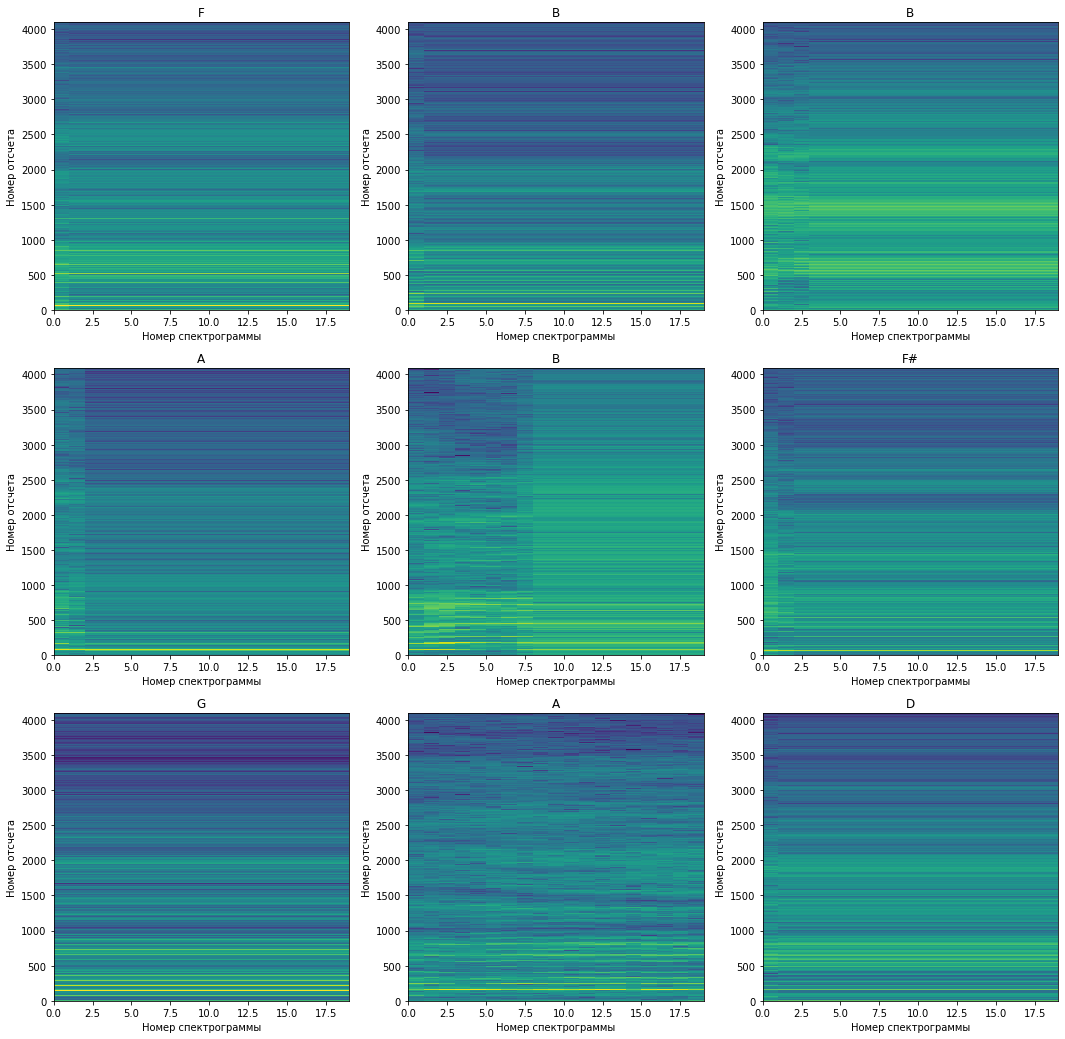

In [88]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
#for i, (spectrogram, label_id) in enumerate(spectr.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_ylabel('Номер отсчета')
    axes[r][c].set_xlabel('Номер спектрограммы')


plt.show()

In [89]:
EPOCHS = 50

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('input_shape',input_shape)

input_shape (20, 4097)


In [91]:
print('---------------------------------------------------------------------')
print('Шаг:', params_s_f[k_max][0], ', количество спектрограмм: ',params_s_f[k_max][1])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

mymodel = create_model(input_shape)

start_time = time.time()
myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Шаг:', params_s_f[k_max][0], ', количество спектрограмм: ',params_s_f[k_max][1], ', accuracy тестовой выборки: ', test_acc, '%')

---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  20
2022-06-10 00:14:13
Epoch 1/50
296/296 [==============================] - 50s 167ms/step - loss: 0.6373 - accuracy: 0.9413 - val_loss: 0.4254 - val_accuracy: 0.9446
Epoch 2/50
296/296 [==============================] - 44s 149ms/step - loss: 0.3298 - accuracy: 0.9555 - val_loss: 0.3647 - val_accuracy: 0.9548
Epoch 3/50
296/296 [==============================] - 45s 151ms/step - loss: 0.3167 - accuracy: 0.9621 - val_loss: 0.3399 - val_accuracy: 0.9569
Epoch 4/50
296/296 [==============================] - 45s 153ms/step - loss: 0.2017 - accuracy: 0.9649 - val_loss: 0.4170 - val_accuracy: 0.9531
Epoch 5/50
296/296 [==============================] - 45s 152ms/step - loss: 0.2006 - accuracy: 0.9676 - val_loss: 0.3505 - val_accuracy: 0.9567
Epoch 6/50
296/296 [==============================] - 45s 151ms/step - loss: 0.2598 - accuracy: 0.9711 - val_loss: 0.3792 - val_accuracy: 0.9578

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для для шага 2048 и 20 спектрограмм на 50 эпохах')]

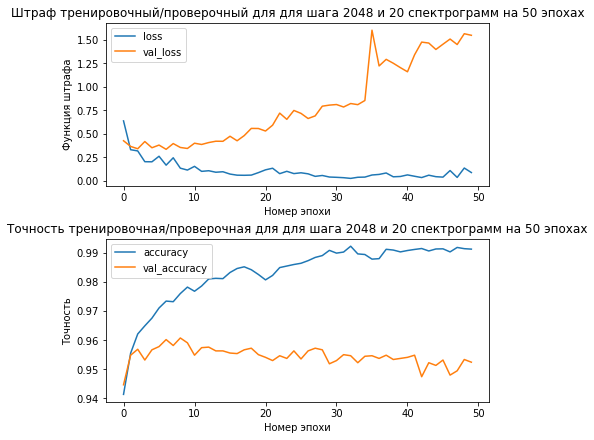

In [92]:
metrics = myhistory.history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм на 50 эпохах')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм на 50 эпохах')